#### TODO
1. Recreate Notebook
2. Bring in data in: room data, cluster data, amenities, distances to sites
3. Look at qq plots, jaque-bera and box-cox methods to determine the best transforms
4. Transform data to best meet normality
5. Build models for room data, cluster data, amenities, disances to sites
6. Use models: LinearRegression, RandomForestRegressor, SVR, XGBoostRegressor
7. Tune models using Hyperopt to tune models

In [103]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer, normalize
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import dbscan
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.ensemble import RandomForestRegressor

# Hyperopt
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
from functools import partial

# Others
from sklearn_pandas import DataFrameMapper
import statsmodels.api as sm
import tilemapbase as tmb
from math import acos, sin, cos
from scipy.stats import jarque_bera
from scipy.stats import boxcox
from scipy.stats import yeojohnson

In [101]:
bc = yeojohnson(rooms['bedrooms'])

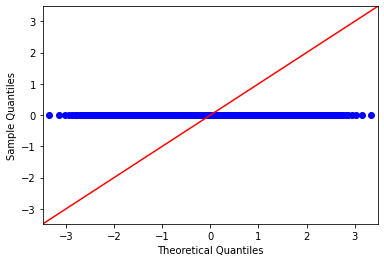

In [102]:
fig = sm.qqplot(bcs, line='45')

In [2]:
def plot_rooms(frame, extent, view_map):
    """
    Plots an openstreetmap with colored points
    
    param frame: A dataframe with lng and lat features.
    param extent: a tilemapbase extent object that defines the map view window.
    param view_map: tilemapbase cached map information.
    """
    
    fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    plotter = tmb.Plotter(extent, view_map, width=600)
    plotter.plot(ax, view_map)

    lats = []
    lngs = []
    for idx, row in rooms.iterrows():
        x, y = tmb.project(row['lng'], row['lat'])
        lngs.append(x)
        lats.append(y)

    #x, y = tmb.project(*first_point)
    #print(x, y)
    #ax.scatter(x,y, marker=".", color="black", linewidth=1)
    ax.scatter(lngs, lats, marker=".", linewidth=1, c=rooms['cluster'])
    
    return None

In [3]:
def linear_distance(latitude1, longitude1, latitude2, longitude2):
    """Calculates the distance between two point with values given in
    latitude and longitude."""
    PI = 3.14159
    distance = acos( sin(PI * latitude1 / 180.0) * \
                     sin(PI * latitude2 / 180.0) + \
                     cos(PI * latitude1 / 180.0) * \
                     cos(PI * latitude2 / 180.0) * \
                     cos(PI * longitude1 / 180.0 - \
                     PI * longitude2 / 180.0) ) * 6378
    return distance


In [4]:
sites = {'Gold_Museum': (4.6019, -74.0718),
        'Monserrate': (4.6057, -74.0555),
        'Bolivar_Square': (4.5981, -74.0760),
        'Museo_Boltero': (4.5968, -74.0732),
        'Museo_Nacional_de_Colombia': (4.6155, -74.0683),
        'Bogota_Botanical_Garden': (4.6682, -74.1000),
        'Simon_Bolivar_Park': (4.6585, -74.0935),
        'Museo_Quinta_Bolivar': (4.6025, -74.0630),
        'Catedral_Primada_de_Colombia': (4.5973, -74.0747),
        'Maloka_Interavtive_Center': (4.6551, -74.1094),
        'Chorro_de_Quevedo': (4.5972, -74.0697),
        'Parque_de_los_Novios': (4.6548, -74.0812)}

In [5]:
def distance_to_sites(data, lat_col, lng_col, sites):
    distances = {}
    for key in sites.keys():
        distances[key] = []
    
    for idx, row in data.iterrows():
        for key, latlng in sites.items():
            distances[key].append(round(linear_distance(latlng[0], latlng[1], row[lat_col], row[lng_col]), 3))
    
    return pd.DataFrame(distances, index=data.index)

In [6]:
# Globals
SEED = 42

In [82]:
# np.random.seed(987654321)
# x = np.random.normal(1, 1, 100000)
# jarque_bera_test = jarque_bera(x)
# jarque_bera_test

# jarque_bera_test.statistic

# jarque_bera_test.pvalue

0.0945822550304295

In [7]:
# Read in room data
rooms = pd.read_csv('../data/room_data.csv')
rooms = rooms.drop_duplicates()
rooms['isSuperhost'] = rooms['isSuperhost'].astype(int)
rooms['avgRating'] = rooms['avgRating'].fillna(rooms['avgRating'].mean())
rooms = rooms.set_index('id')
rooms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2435 entries, 18669058 to 16214536
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cleaning_fee    2435 non-null   int64  
 1   price           2435 non-null   int64  
 2   bedrooms        2428 non-null   float64
 3   beds            2415 non-null   float64
 4   bathrooms       2435 non-null   float64
 5   personCapacity  2435 non-null   int64  
 6   reviewsCount    2435 non-null   int64  
 7   isSuperhost     2435 non-null   int64  
 8   avgRating       2435 non-null   float64
 9   lat             2435 non-null   float64
 10  lng             2435 non-null   float64
dtypes: float64(6), int64(5)
memory usage: 228.3 KB


In [8]:
# Bedrooms and beds have some NaN values. Filling those with zero.
rooms['bedrooms'] = rooms['bedrooms'].fillna(0)
rooms['beds'] = rooms['beds'].fillna(0)

In [9]:
# Check our dataframe contents.
rooms.head()

,cleaning_fee,price,bedrooms,beds,bathrooms,personCapacity,reviewsCount,isSuperhost,avgRating,lat,lng
id,,,,,,,,,,,
18669058,5,10,1.0,1.0,1.0,2,82,0,4.71,4.65030,-74.06013
32308869,12,12,1.0,1.0,1.0,2,52,0,4.50,4.64668,-74.07234
35159913,5,12,1.0,1.0,1.0,2,8,0,5.00,4.58942,-74.07299
37721845,11,11,1.0,1.0,1.0,2,20,0,4.70,4.63778,-74.06339
35522458,8,12,1.0,1.0,1.0,2,18,0,4.94,4.64031,-74.06816


In [10]:
hist_cols = rooms.columns.drop(['isSuperhost', 'lat', 'lng'])
hist_cols

Index(['cleaning_fee', 'price', 'bedrooms', 'beds', 'bathrooms',
       'personCapacity', 'reviewsCount', 'avgRating'],
      dtype='object')

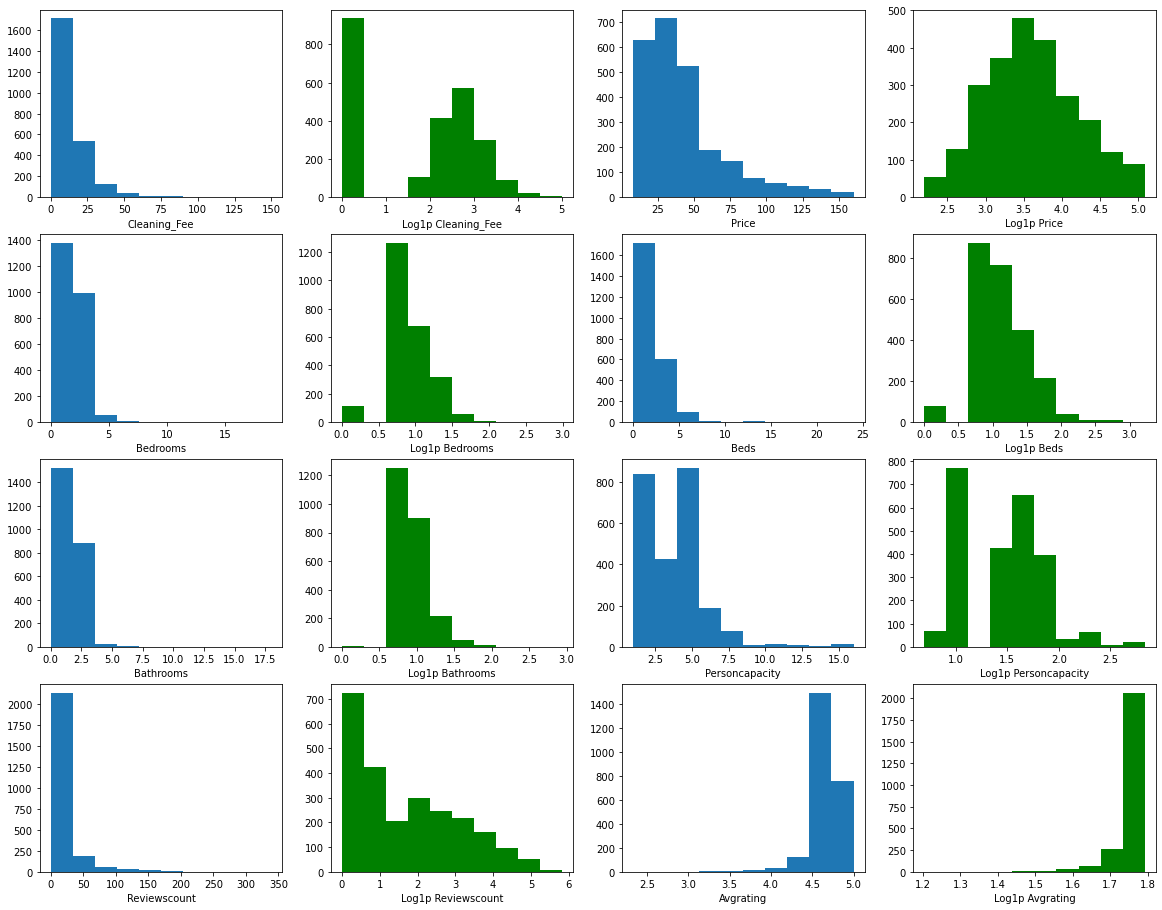

In [11]:
plt.figure(figsize=(20, 20))
idx = 1
for col in hist_cols:
    plot_nbr = idx 
    plt.subplot(5, 4, plot_nbr)
    plt.hist(rooms[col])
    plt.xlabel(col.title())
    idx += 1
    plot_nbr = idx 
    plt.subplot(5, 4, plot_nbr)
    plt.hist(np.log1p(rooms[col]), color='green')
    plt.xlabel('Log1p ' + col.title())
    idx += 1

In [ ]:
lt.figure(figsize=(20, 20))
idx = 1
for col in hist_cols:
    plot_nbr = idx 
    plt.subplot(5, 4, plot_nbr)
    plt.hist(rooms[col])
    plt.xlabel(col.title())
    idx += 1
    plot_nbr = idx 
    plt.subplot(5, 4, plot_nbr)
    plt.hist(np.log1p(rooms[col]), color='green')
    plt.xlabel('Log1p ' + col.title())
    idx += 1

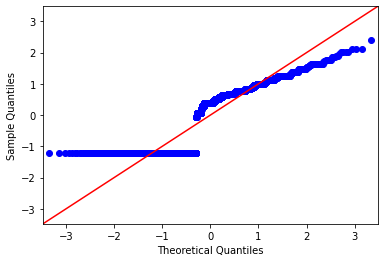

In [25]:
ss = StandardScaler()
cf = ss.fit_transform(np.log1p(rooms['cleaning_fee'].values.reshape(-1, 1)))
cf = cf.reshape(1, -1)
fig = sm.qqplot(cf[0], line='45')

In [84]:
def plotidxs():
    idxs = np.array([0, 1, 2, 3])
    while True:
        yield idxs
        idxs += 4

In [65]:
tx_rooms = rooms[hist_cols].copy()
ss_rooms = pd.DataFrame(StandardScaler().fit_transform(tx_rooms), columns=hist_cols)
log_rooms = pd.DataFrame(FunctionTransformer(np.log1p).fit_transform(tx_rooms), columns=hist_cols)
ss_log_rooms = pd.DataFrame(StandardScaler().fit_transform(log_rooms), columns=hist_cols)

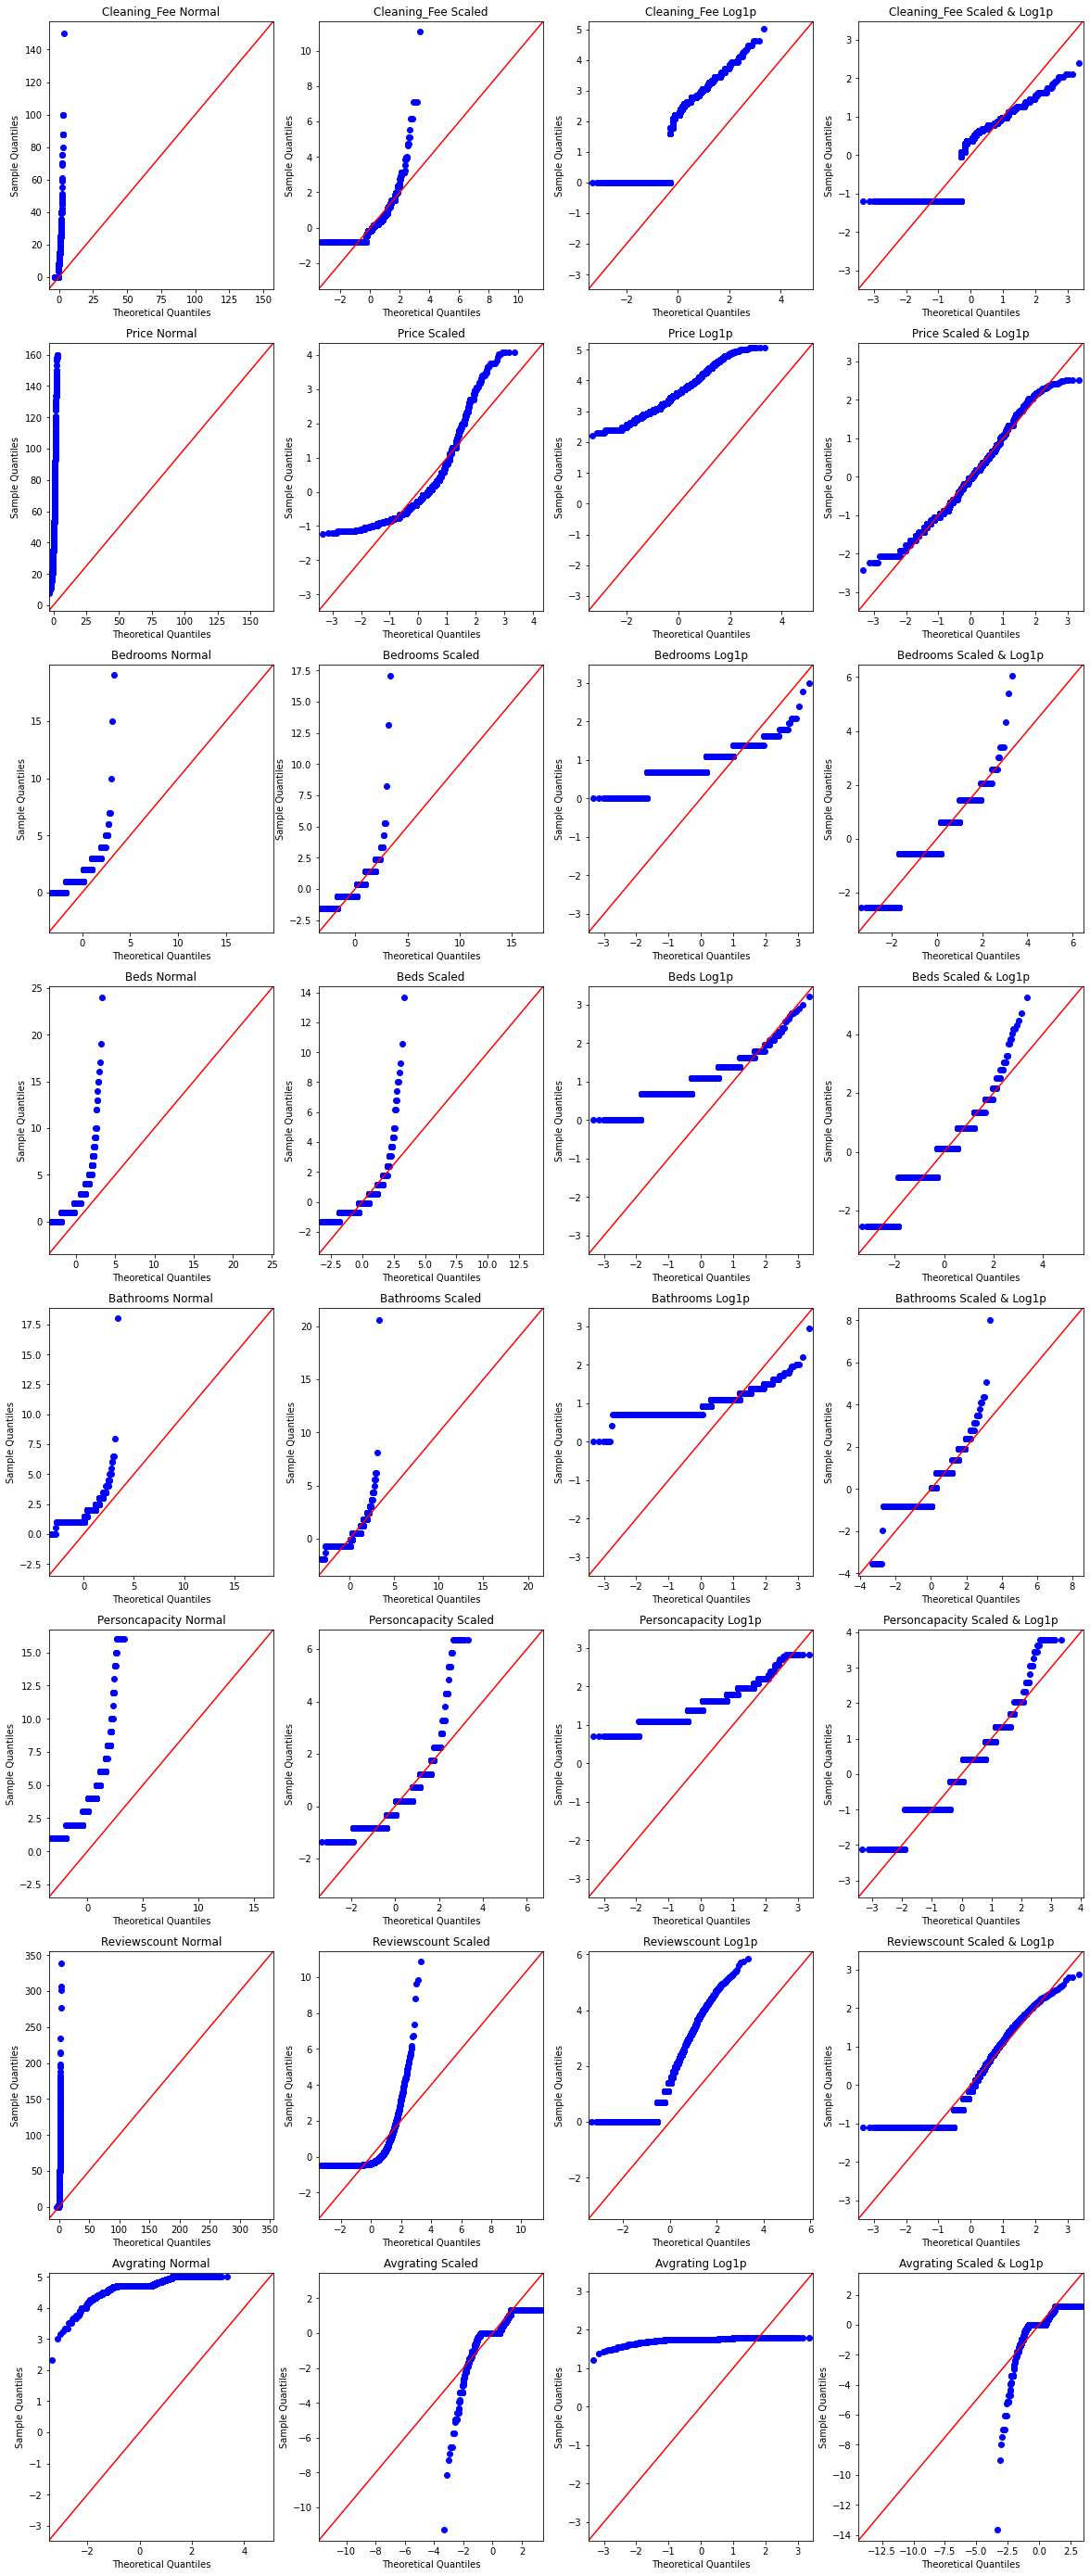

In [85]:
pp = plotidxs()
fig, axes = plt.subplots(len(hist_cols), 4, figsize=(20,50))
ax = axes.flatten()
for idx, col in enumerate(hist_cols):
    ax_plots = next(pp)
    sm.qqplot(tx_rooms[col], line='45', ax=ax[ax_plots[0]])
    ax[ax_plots[0]].set_title(col.title() + ' Normal')
    sm.qqplot(ss_rooms[col], line='45', ax=ax[ax_plots[1]])
    ax[ax_plots[1]].set_title(col.title() + ' Scaled')
    sm.qqplot(log_rooms[col], line='45', ax=ax[ax_plots[2]])
    ax[ax_plots[2]].set_title(col.title() + ' Log1p')
    sm.qqplot(ss_log_rooms[col], line='45', ax=ax[ax_plots[3]])
    ax[ax_plots[3]].set_title(col.title() + ' Scaled & Log1p')


In [77]:
pidx = plot_idxs()

[0 1 2 3]
[4 5 6 7]
[ 8  9 10 11]
[12 13 14 15]


[48 49 50 51]
[52 53 54 55]
[56 57 58 59]
[60 61 62 63]


In [12]:
distances = distance_to_sites(rooms, 'lat', 'lng', sites)
distances.head()

,Gold_Museum,Monserrate,Bolivar_Square,Museo_Boltero,Museo_Nacional_de_Colombia,Bogota_Botanical_Garden,Simon_Bolivar_Park,Museo_Quinta_Bolivar,Catedral_Primada_de_Colombia,Maloka_Interavtive_Center,Chorro_de_Quevedo,Parque_de_los_Novios
id,,,,,,,,,,,,
18669058,5.541,4.991,6.072,6.129,3.978,4.852,3.813,5.330,6.117,5.493,6.006,2.391
32308869,4.985,4.930,5.423,5.553,3.500,3.893,2.691,5.026,5.503,4.217,5.516,1.335
35159913,1.395,2.655,1.022,0.822,2.949,9.267,8.019,1.830,0.897,8.353,0.940,7.335
37721845,4.102,3.677,4.633,4.690,2.539,5.288,4.060,3.928,4.678,5.457,4.571,2.738
35522458,4.295,4.101,4.779,4.876,2.762,4.703,3.465,4.248,4.842,4.863,4.802,2.167


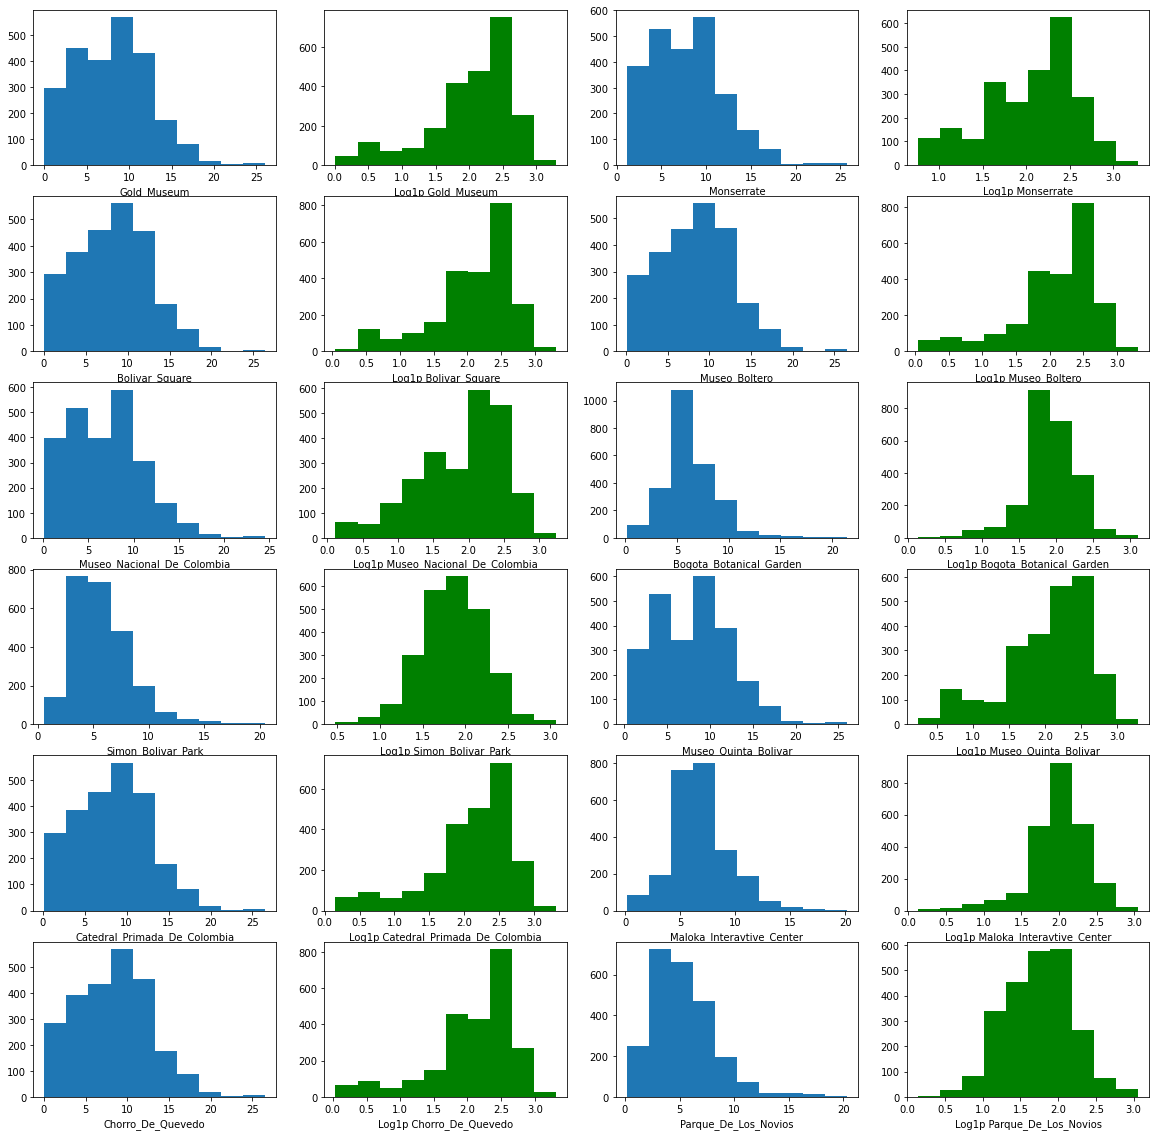

In [13]:
plt.figure(figsize=(20, 20))
plot_nbr = 1
for col in distances.columns:
    plt.subplot(6, 4, plot_nbr)
    plt.hist(distances[col])
    plt.xlabel(col.title())
    plot_nbr += 1
    plt.subplot(6, 4, plot_nbr)
    plt.hist(np.log1p(distances[col]), color='green')
    plt.xlabel('Log1p ' + col.title())
    plot_nbr += 1

In [14]:
===

SyntaxError: invalid syntax (<ipython-input-14-3dd4ea5ba507>, line 1)

In [ ]:
# Read in amenities data from a json object.
with open('../data/amenities_strings.json', 'r') as f:
    amenities_dict = json.load(f)

In [ ]:
# Convert each entry in the amenities_dict to a document. Replace spaces with underscores
# any other non-alphanumeric character with and underscore.
corpus = []
key_list = []
for key, word_list in amenities_dict.items():
    
    try:
        integer_key = int(key)
        key_list.append(integer_key)
    except Exception as e:
        raise e
    cleaned_word_list = [re.sub(r'(\s+|\W+)', '_', doc) for doc in word_list]
    document = ' '.join(cleaned_word_list)
    corpus.append(document)

In [ ]:
# Fit a CountVectorizer
cv = CountVectorizer()
amenities_vec = cv.fit_transform(corpus)
cv.get_feature_names()[:5]

______
**Amenities data is loaded below.**  
This will be added to the analysis later after dong an initial analysis without it.

In [ ]:
# Convert transformed CountVecortizer data to a DataFrame with room ids as
# the index.
amenities_vec = amenities_vec.toarray()
amenities = pd.DataFrame(amenities_vec, index=key_list)
amenities.head()

In [ ]:
# Validate that the length of the imput list of amenities is equal to the sum
# of the amenities in the row for the equivalent id.
for key, val in amenities_dict.items():
    assert len(val) == sum(amenities.loc[int(key)])

In [ ]:
amenities.shape

In [ ]:
rooms.shape

In [ ]:
distances = distance_to_sites(rooms, 'lat', 'lng', sites)
distances.head()

In [ ]:
distances.shape

In [ ]:
# Drop latitude and longitude from rooms, and combine the three DataFrames.
rooms = rooms.drop(['lat', 'lng'], axis=1)
rooms_cols = rooms.columns
amenities_cols = amenities.columns
distances_cols = distances.columns

room_data = rooms.merge(amenities, left_index=True, right_index=True, how='inner')
room_data = room_data.merge(distances, left_index=True, right_index=True, how='inner')
room_data.head()

In [ ]:
room_data.shape

In [ ]:
# Compare correlation values for price and log of the price with the features before
# and after taking the log of the feaures.
# price_r and log_price_r os the correlation to normal features.
# price_l and log_price_l is for the correlation with the log of the features. 
rooms['log_price'] = np.log(rooms['price'])
fields_to_compare = ['price', 'log_price',  'bedrooms', 'beds', 'bathrooms','personCapacity',
                     'reviewsCount', 'isSuperhost', 'avgRating', 'cleaning_fee']
log_rooms = rooms[fields_to_compare].copy()
features_to_log = ['bedrooms', 'beds', 'bathrooms', 'personCapacity', 'cleaning_fee']
for feature in features_to_log:
    log_rooms[feature] = np.log1p(log_rooms[feature])
r = rooms[fields_to_compare].corr()
l = log_rooms.corr()
features = ['price', 'log_price']
r[features].merge(l[features], left_index=True, right_index=True, suffixes=('_r', '_l'))

**Based on the correlation values above price will be fit with the following features:**  
log of bedrooms  
log of beds  
log of bathrooms  
log of personCapacity  
reviewsCount - low correlation so likely noise  
isSuperhost - low correlation so likely noise  
avgRating - low correlation so likely noise  
cleaning_fee  

______  
### Clustering with Latitude and Longitude

In [ ]:
# use Tilemapbase to create a map of all the room locations.
import tilemapbase as tmb
t_map = None

In [ ]:
tmb.start_logging()
if not t_map:
    tmb.init(create=True)
    t_map = tmb.tiles.build_OSM()

In [ ]:
latitude_range = (rooms['lat'].min() - 0.003, rooms['lat'].max() + 0.003)
longitude_range = (rooms['lng'].min() - 0.003, rooms['lng'].max() + 0.003)
(latitude_range, longitude_range)

In [ ]:
extent = tmb.Extent.from_lonlat(longitude_range[0],
                                        longitude_range[1],
                                        latitude_range[0],
                                        latitude_range[1])
extent = extent.to_aspect(1.0)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tmb.Plotter(extent, t_map, width=600)
plotter.plot(ax, t_map)

first_point = (rooms.iloc[0]['lng'], rooms.iloc[0]['lat'])
print(first_point)

lats = []
lngs = []
for idx, row in rooms.iterrows():
    x, y = tmb.project(row['lng'], row['lat'])
    lngs.append(x)
    lats.append(y)

#x, y = tmb.project(*first_point)
#print(x, y)
#ax.scatter(x,y, marker=".", color="black", linewidth=1)
ax.scatter(lngs, lats, marker=".", color="black", linewidth=1)

______
**Starting with KMeans clustering, look at the interia & sillhouette scores to help determine the proper number of clusters.**

In [ ]:
points = rooms[['lng', 'lat']]

In [ ]:
inertia_scores = []
silhouette_scores = []
clusters = []
for i in range(2, 50):
    km = KMeans(n_clusters=i, init='k-means++', random_state=SEED)
    clusters.append(i)
    labels = km.fit_predict(points)
    inertia_scores.append(km.inertia_)
    silhouette_scores.append(silhouette_score(points, labels))

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia Score')
plt.plot(np.arange(len(inertia_scores)), inertia_scores)
plt.subplot(1, 2, 2)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.plot(np.arange(len(silhouette_scores)), silhouette_scores)

In [ ]:
# Find the 
for idx, val in enumerate(silhouette_scores[:10]):
    print(idx, round(val, 4))

______
**The inertia elbow doesn't have a clear joint. Silhouette scores aren't very informative, but seem to stay in a close range between ~15 & ~30.**  
Using 27 clusters (index 25) as it has the highest silhouette score in that range.

In [ ]:
km = KMeans(n_clusters=27, init='k-means++', random_state=SEED)
labels = km.fit_predict(points)

In [ ]:
rooms['cluster'] = labels

In [ ]:
plot_rooms(rooms, extent, t_map)

In [ ]:
cluster_dummies = pd.get_dummies(rooms['cluster'], drop_first=True)

In [ ]:
cluster_dummies.head()

In [ ]:
cluster_dummies.shape

In [ ]:
rooms = rooms.merge(cluster_dummies, left_index=True, right_index=True, how='inner')
rooms.shape

In [ ]:
PATH

In [ ]:
asdf == abcd

In [ ]:
# Pairplot with unchanged feaures.
pair_plot_features = ['price', 'log_price', 'bedrooms', 'beds', 'bathrooms', 'personCapacity', 'cleaning_fee']
sns.pairplot(rooms[pair_plot_features]);

In [ ]:
# Pairplot with logs of ['bedrooms', 'beds', 'bathrooms', 'personCapacity', 'cleaning_fee']
sns.pairplot(log_rooms[pair_plot_features]);

In [ ]:
# Create DataFrames for train_test_split.
# One unchanged from original data as a control.
# One with the log of the selected features.
logs = ['bedrooms', 'beds', 'bathrooms', 'personCapacity']
X_r = rooms.drop(['price', 'log_price', 'lat', 'lng'], axis=1)
y_r = rooms['price']
X_l = rooms.drop(['price', 'log_price', 'lat', 'lng'], axis=1)
for item in logs:
    X_l[item] = np.log1p(X_l[item])
y_l = rooms['price']

______
**Xr_ prefix is for room data unchanged prior to the split.**  
**Xl_ prefix is for room data that has had np.log applied to some of the fields.**  

In [ ]:
# Train test splits
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_r, y_r, test_size=0.2, random_state=SEED, stratify=np.floor(np.log2(y_r)))
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X_l, y_l, test_size=0.2, random_state=SEED, stratify=np.floor(np.log2(y_l)))

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(yr_train);
plt.subplot(1, 2, 2)
plt.hist(yr_test);

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(yl_train);
plt.subplot(1, 2, 2)
plt.hist(yl_test);

In [ ]:
# Baseline regression to see p-Values
Xr_train_with_constant = sm.add_constant(Xr_train)
model = sm.OLS(yr_train, Xr_train_with_constant)
fit = model.fit()
fit.summary()

In [ ]:
# Baseline regression to see p-Values
Xl_train_with_constant = sm.add_constant(Xl_train)
model = sm.OLS(yr_train, Xl_train_with_constant)
fit = model.fit()
fit.summary()

______  
**It is interesting that neither bedrooms or beds seems to be particularly important to the model. Values that don't seem to correlate well such as reviewsCount, and avgRating are important.**

In [ ]:
# Fit a LinearRegression with StandardScaler
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(Xr_train, np.log(yr_train))
yr_pred = pipe.predict(Xr_train)
r2_score(yr_pred, np.log(yr_train))

In [ ]:
plt.scatter(yr_pred, yr_train);

In [ ]:
# Fit a LinearRegression with StandardScaler
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(Xl_train, np.log(yl_train))
yl_pred = pipe.predict(Xl_train)
r2_score(yl_pred, np.log(yl_train))

In [ ]:
plt.scatter(yl_pred, yl_train);

In [ ]:
Xr_train2 = Xr_train.drop(['reviewsCount', 'isSuperhost', 'avgRating'], axis=1)
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(Xr_train2, np.log(yr_train))
yr_pred = pipe.predict(Xr_train2)
r2_score(yr_pred, np.log(yr_train))

In [ ]:
# Cross val score of scales but unchanged input features.
pipe = make_pipeline(StandardScaler(), LinearRegression())
cross_val_score(pipe, Xr_train, yr_train)

In [ ]:
# Cross val score with the log of input features i.e. ['bedrooms', 'beds', 'bathrooms', 'personCapacity']
pipe = make_pipeline(StandardScaler(), LinearRegression())
cross_val_score(pipe, Xl_train, yl_train)

______
**Logs of the input features ['bedrooms', 'beds', 'bathrooms', 'personCapacity'] appears to yield better results in general.**

In [ ]:
Xl_train.head()

In [ ]:
Xl_train.shape

In [ ]:
Xl_train = Xl_train.merge(cluster_dummies, left_index=True, right_index=True, how='inner')

In [ ]:
Xl_train.head()

In [ ]:
cross_val_score(pipe, Xl_train, yl_train)

In [ ]:
pipe.fit(Xl_train, yl_train)
yl_pred = pipe.predict(Xl_train)

In [ ]:
plt.scatter(yl_pred, yl_train)

In [ ]:
np.corrcoef(yl_pred, yl_train)

In [ ]:
rf_pipe = make_pipeline(StandardScaler(), RandomForestRegressor())
rf_pipe.fit(Xl_train, yl_train)
rf_pred = rf_pipe.predict(Xl_train)

In [ ]:
r2_score(rf_pred, yl_pred)

In [ ]:
plt.scatter(rf_pred, yl_train)

In [ ]:
cross_val_score(rf_pipe, Xl_train, yl_train)

In [ ]:
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
from functools import partial

In [ ]:
def obj(hps, X, y, ncv=3):
    model = RandomForestRegressor(**hps)
    cvs = cross_val_score(model, X, y, cv=ncv, scoring='neg_mean_squared_error')
    
    avg_score = cvs.mean()
    
    return -avg_score

In [ ]:
from hyperopt import fmin, tpe, hp
best = fmin(fn=lambda x: x ** 2,
    space=hp.uniform('x', -10, 10),
    algo=tpe.suggest,
    max_evals=500)
print(best)

In [ ]:
hp_space = {
    'n_estimators': ho_scope.int(hp.quniform('n_estimators', low=100, high=500, q=25)), 
    #'criterion': hp.choice('criterion', ['gini', 'entropy']), 
    #'max_features': hp.uniform('max_features', low=0.25, high=0.75),
    'max_depth': ho_scope.int(hp.quniform('max_depth', low=3, high=10, q=5))
}

In [ ]:
ho_sample(hp_space)

In [ ]:
trials = Trials()

In [ ]:
best_rf = fmin(partial(obj, X=Xl_train, y=yl_train), hp_space, algo=tpe.suggest, max_evals=300, trials=trials, rstate=np.random.RandomState(SEED))

In [ ]:
best_rf

In [ ]:
cross_val_score(RandomForestRegressor(n_estimators=150, max_depth=10), Xl_train, yl_train)

In [ ]:
rf = RandomForestRegressor(n_estimators=150, max_depth=10)

In [ ]:
rf.fit(Xl_train, yl_train)

In [ ]:
rf_pred = rf.predict(Xl_train)
r2_score(rf_pred, yl_train)